In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm

In [2]:
path = "/home/hasu/Documents/github/content/archive/boats/"

In [3]:
# ls /home/hasu/Documents/github/content/archive/boats/buoy

In [14]:
transform = transforms.Compose([
    transforms.Resize([224,224]),
    transforms.RandomRotation(degrees=[-30, 30]),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomGrayscale(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = torchvision.datasets.ImageFolder(path, transform = transform)

train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size = 16, shuffle = True, num_workers = 2)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size = 16, shuffle = True, num_workers = 2)

In [15]:
len(dataset)

1462

In [16]:
dataset.classes

['buoy',
 'cruise ship',
 'ferry boat',
 'freight boat',
 'gondola',
 'inflatable boat',
 'kayak',
 'paper boat',
 'sailboat']

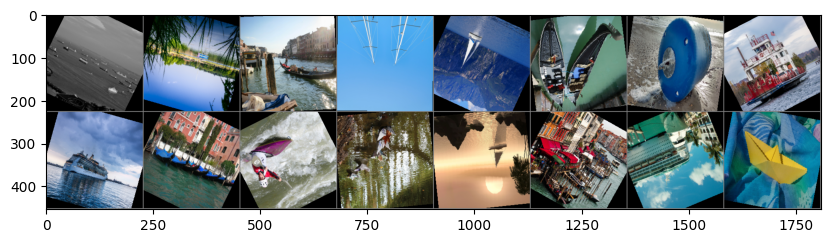

In [17]:
def imshow(img):
    plt.figure(figsize = (10, 10))
    img = img / 2 + 0.5  #unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
    

# Building Model

In [21]:
net = torchvision.models.resnet18(weights = True)

In [22]:
net

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Editing the layers

In [23]:
for param in net.parameters():
    param.requires_grad= False

In [24]:
net.fc = nn.Linear(512, 9) #as we have 9 classes

In [25]:
net

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [28]:
net(images).shape  #net(images.cuda()).shape if you have GPU

torch.Size([16, 9])

In [30]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr = 0.01)

In [31]:
def get_quality(net):
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    print('Accuracy of the network on test images: %d %%' % (100 * correct / total))
    

def train_network(net, n_epochs = 10):
    losses = []
    for epoch in range(n_epochs):
        running_loss = 0.0
        for i, data in enumerate(tqdm(trainloader)):
            #get the input
            images, labels = data
            
            #zero the parameter gradient
            optimizer.zero_grad()
            
            #foword + backword + optimize
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            #print statistics
            running_loss += loss.item()
            losses.append(loss.item())
            
        print('[%d, %5d] loss: %.3f'%
              (epoch + 1, i + 1, running_loss / 2000))
        running_loss = 0.0
        
        get_quality(net)
        
    plt.plot(losses, 'b')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    
    print('Finish training!')

100%|███████████████████████████████████████████| 64/64 [01:11<00:00,  1.12s/it]

[1,    64] loss: 0.064


Accuracy of the network on test images: 60 %


100%|███████████████████████████████████████████| 64/64 [01:21<00:00,  1.27s/it]

[2,    64] loss: 0.037


Accuracy of the network on test images: 70 %


100%|███████████████████████████████████████████| 64/64 [01:03<00:00,  1.01it/s]

[3,    64] loss: 0.033


Accuracy of the network on test images: 70 %


100%|███████████████████████████████████████████| 64/64 [01:02<00:00,  1.02it/s]

[4,    64] loss: 0.037


Accuracy of the network on test images: 66 %


100%|███████████████████████████████████████████| 64/64 [00:53<00:00,  1.19it/s]

[5,    64] loss: 0.046


Accuracy of the network on test images: 63 %
Finish training!


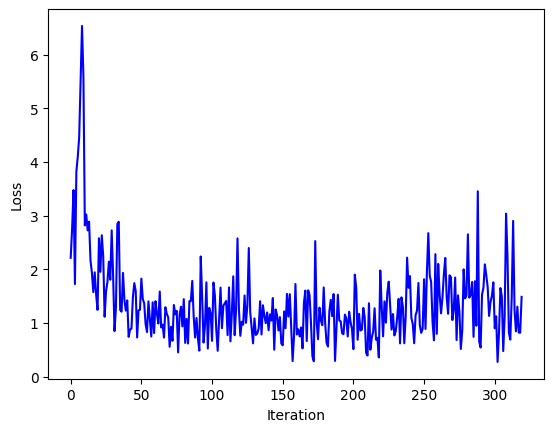

In [32]:
train_network(net, n_epochs=5)

100%|███████████████████████████████████████████| 64/64 [00:56<00:00,  1.13it/s]

[1,    64] loss: 0.037


Accuracy of the network on test images: 66 %


100%|███████████████████████████████████████████| 64/64 [00:50<00:00,  1.26it/s]

[2,    64] loss: 0.040


Accuracy of the network on test images: 66 %


100%|███████████████████████████████████████████| 64/64 [00:52<00:00,  1.22it/s]

[3,    64] loss: 0.036


Accuracy of the network on test images: 67 %


100%|███████████████████████████████████████████| 64/64 [00:51<00:00,  1.23it/s]

[4,    64] loss: 0.035


Accuracy of the network on test images: 65 %


100%|███████████████████████████████████████████| 64/64 [00:52<00:00,  1.21it/s]

[5,    64] loss: 0.041


Accuracy of the network on test images: 68 %


100%|███████████████████████████████████████████| 64/64 [00:52<00:00,  1.22it/s]

[6,    64] loss: 0.038


Accuracy of the network on test images: 66 %


100%|███████████████████████████████████████████| 64/64 [00:52<00:00,  1.22it/s]

[7,    64] loss: 0.040


Accuracy of the network on test images: 69 %


100%|███████████████████████████████████████████| 64/64 [00:51<00:00,  1.23it/s]

[8,    64] loss: 0.037


Accuracy of the network on test images: 71 %


100%|███████████████████████████████████████████| 64/64 [00:54<00:00,  1.17it/s]

[9,    64] loss: 0.041


Accuracy of the network on test images: 66 %


100%|███████████████████████████████████████████| 64/64 [00:55<00:00,  1.15it/s]

[10,    64] loss: 0.036


Accuracy of the network on test images: 67 %


100%|███████████████████████████████████████████| 64/64 [00:52<00:00,  1.23it/s]

[11,    64] loss: 0.043


Accuracy of the network on test images: 60 %


100%|███████████████████████████████████████████| 64/64 [00:59<00:00,  1.08it/s]

[12,    64] loss: 0.041


Accuracy of the network on test images: 68 %


100%|███████████████████████████████████████████| 64/64 [00:59<00:00,  1.07it/s]

[13,    64] loss: 0.033


Accuracy of the network on test images: 66 %


100%|███████████████████████████████████████████| 64/64 [01:00<00:00,  1.06it/s]

[14,    64] loss: 0.030


Accuracy of the network on test images: 54 %


100%|███████████████████████████████████████████| 64/64 [01:11<00:00,  1.12s/it]

[15,    64] loss: 0.034


Accuracy of the network on test images: 73 %
Finish training!


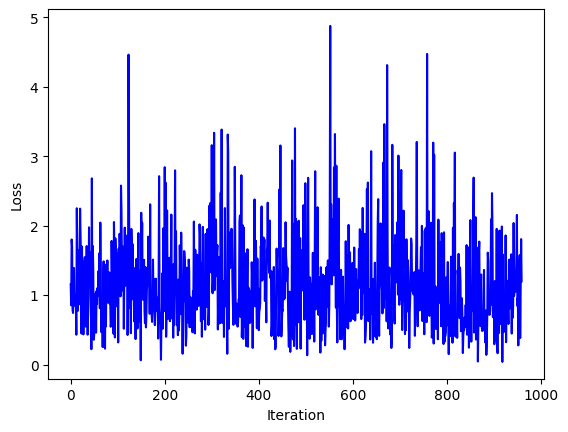

In [34]:
train_network(net, n_epochs=15)